In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

from champ_optics_Model import MCMC_Model,get_mean_err

from glob import glob
from pathlib import PurePath,Path

c:\Users\xiaod\.conda\envs\CCATholo\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_samples(data_List):
    data_samples=np.zeros([data_List[0].shape[0],len(data_List)])
    for idx, data in enumerate(data_List):
        data_samples[:,idx] = data[:,1]
    x_vec=data_List[0][:,0]

    data_samples_zp = data_samples.copy()
    freq_vec = fft.fftshift(
        fft.fftfreq(
            data_samples_zp.shape[0], 
            np.diff(x_vec).mean()
            )
        )
    spec_samp = fft.fftshift(
        fft.fft(data_samples_zp, axis=0) / (len(freq_vec) // 2)
        )
    
    return x_vec, data_samples, freq_vec, spec_samp

In [3]:
##inputs
Data_folder='./4_30/test_1_95m/find_focus/'
keywords='D_1_95m_*'
outputfolder='../Results/1_95m/'

# 1. read data
D_folder=PurePath(Data_folder)
data_file_list = sorted(glob(str(D_folder / keywords)))
data_list1 = [
    np.genfromtxt(data_file) for data_file in data_file_list
]
z_vec, data_samples1, freq_vec, Spec_samples1 = get_samples(data_list1)

In [4]:
"""Model 1 2nd polynomial model"""
bounds_0 = np.asarray(
    [
        [-8, 0],
        [2, 10],
        [0,100]
    ]
)
Model_2nd = MCMC_Model(
    z_vec, data_samples1, 
    2, 0, 
    bounds_0,
    "2nd poly"
)
Model_2nd.read_mc_chain(outputfolder+'parab_mcmc_analy.h5')

"""Model 2 2nd polynomial model + 1sw"""
bounds_0 = np.asarray(
    [
        [-8,-1],
        [2, 8],
        [45,60],
        [5,20],
        [0.9,0.9999999],
        [-np.pi,np.pi]
    ]
)
Model_2nd_1sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 1, 
    bounds_0,
    "2nd poly + 1sw"
)
Model_2nd_1sw.read_mc_chain(outputfolder+'parab_1sw_mcmc_analy.h5')
"""Model 3 2nd polynomial model + 2sw"""
bounds_0 = np.asarray(
    [
        [-8,-1],
        [2, 8],
        [45,60],
        [10,20],
        [0.95,0.96],
        [-0.68,-0.5],
        [1,10],
        [0.9,1.1],
        [-np.pi,np.pi],
    ]
)
Model_2nd_2sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 2, 
    bounds_0,
    "2nd poly + 2sw"
)
Model_2nd_2sw.read_mc_chain(outputfolder+'parab_2sw_mcmc_analy.h5')

"""Model 4 2nd polynomial model + 3sw"""
bounds_0 = np.asarray(
    [
        [-8,-1],
        [2, 8],
        [45,60],
        [10,20],
        [0.95,0.96],
        [-0.68,-0.5],
        [1,10],
        [0.9,1.1],
        [-np.pi,np.pi],
        [1,10],
        [0.7,0.8],
        [-np.pi,np.pi]
    ]
)

Model_2nd_3sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 3, 
    bounds_0,
    "2nd poly + 3sw"
)
Model_2nd_3sw.read_mc_chain(outputfolder+'parab_3sw_mcmc_analy.h5')


[47.74758442 42.47496238 50.42015112]
(23550, 3)
[ 56.55806316  63.13967869  53.5552436  112.8036848   62.14503829
  56.98750241]
(38000, 6)
[ 80.29152383  48.49228673  65.75637047 130.80892232 150.00317754
 119.46096773 103.23711368 102.11717689  48.36183347]
(41000, 9)
[203.53571815 163.2260539  253.49108445 261.75844383 384.66268506
 243.74615872 384.6799006  521.0679084  478.08114824 251.5421311
 244.42546437 300.863679  ]
(17850, 12)


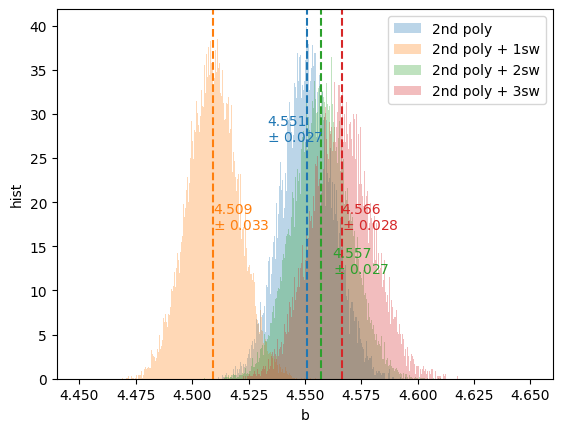

In [5]:
# collect model to list
fit_model_list = [
    Model_2nd,
    Model_2nd_1sw,
    Model_2nd_2sw,
    Model_2nd_3sw
]

b_bins = np.linspace(4.45, 4.65, 1000)
Mean=[]
Std=[]
for idx, fit_model in enumerate(fit_model_list):
    p = plt.hist(
        fit_model.flat_samples[:,1], bins=b_bins,
        density=True,
        alpha=0.3, color=f'C{idx}',
        label=fit_model.model_label
    )
    max=p[0].max()
    mean=fit_model.flat_samples[:,1].mean()
    t=0
    for i in range(len(b_bins)):
        t += (b_bins[i] - mean)**2
    std = np.sqrt(t / np.sum(b_bins))
    Mean.append(mean)
    Std.append(std)
    plt.axvline(x=mean,color=f'C{idx}', linestyle="--")
plt.text(Mean[0]-0.018,max/2+10,"{:.3f}\n$\pm$ {:.3f}".format(Mean[0],Std[0]),color=f'C{0}')
plt.text(Mean[1],max/2,"{:.3f}\n$\pm$ {:.3f}".format(Mean[1],Std[1]),color=f'C{1}')
plt.text(Mean[2]+0.005,max/2-5,"{:.3f}\n$\pm$ {:.3f}".format(Mean[2],Std[2]),color=f'C{2}')
plt.text(Mean[3],max/2,"{:.3f}\n$\pm$ {:.3f}".format(Mean[3],Std[3]),color=f'C{3}')
plt.xlabel("b")
plt.ylabel("hist")
plt.legend()
plt.savefig('./Results/b_1_95.png')
plt.show()

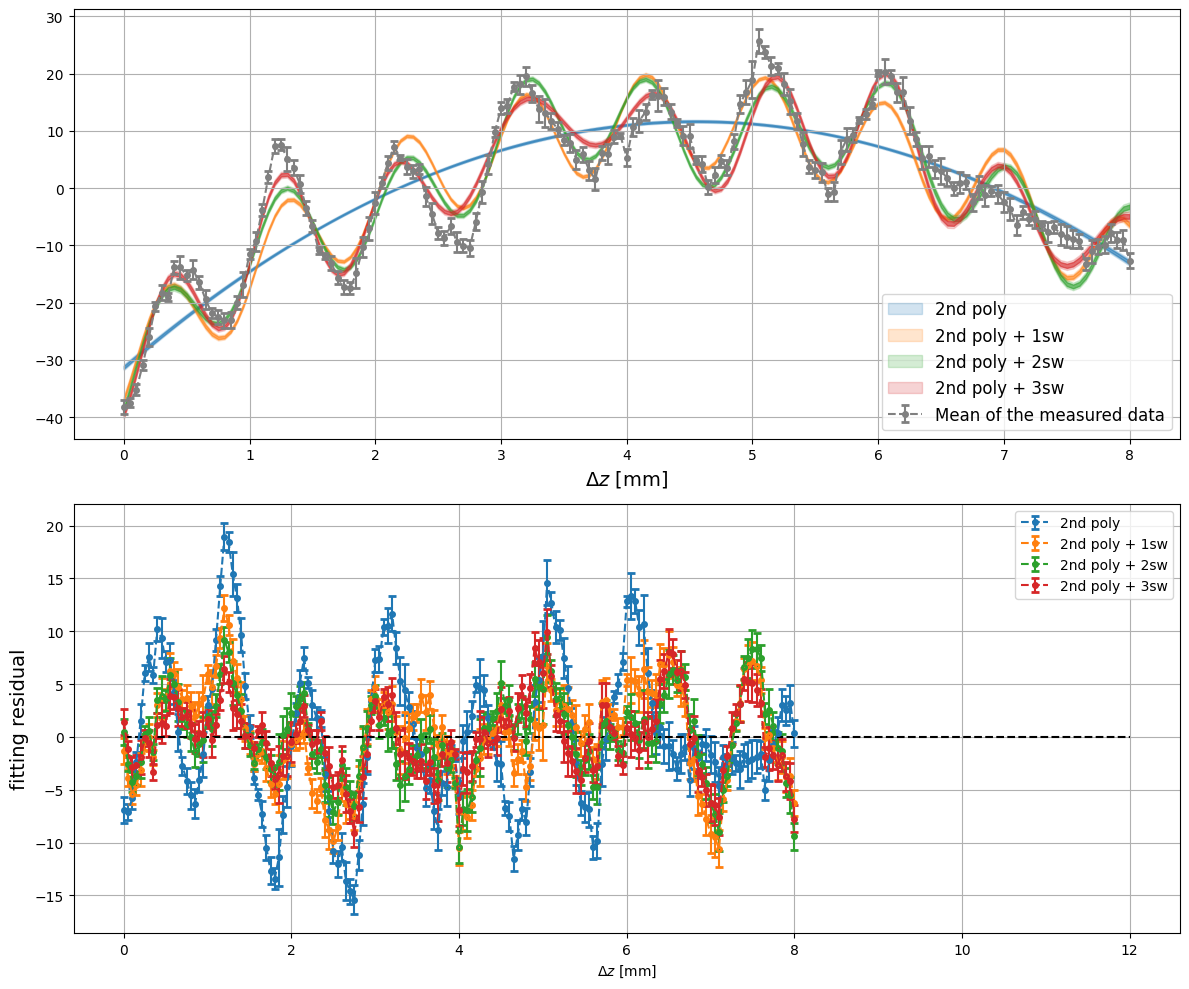

In [6]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.errorbar(
    Model_2nd.x_vec,
    Model_2nd.y_mean,
    yerr=Model_2nd.y_err,
    marker='.', ls='--', color=f'gray',
    label=f"Mean of the measured data",
    capsize=3, markeredgewidth=2,
    fillstyle='none'
)

for idx, fit_model in enumerate(fit_model_list):
    pred_res = fit_model.model_batch(fit_model.flat_samples)
    model_quantil = np.quantile(
        pred_res,
        [0.025, 0.16, 1-0.16, 1-0.025],
        axis=-1
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[0],
        y2=model_quantil[-1],
        color=f"C{idx}",
        alpha=0.2,
        label=fit_model.model_label
    )
    plt.fill_between(
        fit_model.x_vec,
        y1=model_quantil[1],
        y2=model_quantil[-2],
        color=f"C{idx}",
        alpha=0.6,
        #label=fit_model.model_label
    )
plt.grid(which='both', axis='both')
plt.legend(fontsize=12)
plt.xlabel(r'$\Delta z$ [mm]',fontsize=14)

plt.subplot(212)
for idx, fit_model in enumerate(fit_model_list):
    param_mean = np.atleast_2d(fit_model.flat_samples.mean(axis=0))
    pred_res = fit_model.model_batch(param_mean)[:,0]
    plt.errorbar(
        fit_model.x_vec,
        fit_model.y_mean-pred_res,
        yerr=fit_model.y_err,
        marker='.', ls='--', color=f'C{idx}',
        label=fit_model.model_label,
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
plt.hlines(y=0, xmin=0, xmax=12, color='k', ls='--')
plt.grid(which='both', axis='both')
plt.legend()
plt.xlabel(r'$\Delta z$ [mm]')
plt.ylabel('fitting residual',fontsize=14)

plt.tight_layout()
plt.savefig('./Results/result_1_95m.png')